# Machine learning - Features extraction

Runs binary and multi-class classifiers on a given dataset.
Dataset are read as Parquet file. The dataset must contain a feature vector named "features" and a classification column.

## Imports

In [1]:
import pandas as pd
import mltoolkit
from pyspark.sql import SparkSession
import numpy as np
import sklearn

## Configure Spark Session

In [2]:
spark = SparkSession.builder \
                    .master("local[4]") \
                    .appName("datasetClassifier") \
                    .getOrCreate()

## Read in data from parquet file

In [3]:
parquetFile = './input_features/'
data = spark.read.parquet(parquetFile).cache()

df = data.toPandas()
print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 18491


,structureChainId,alpha,beta,coil,foldType,features
0,1LBU.A,0.361502,0.107981,0.530516,other,"[-0.0676212902400502, -0.19547940407580924, 0...."
1,1LC0.A,0.410345,0.275862,0.313793,alpha+beta,"[-0.0792541990609706, 0.040140426752662904, 0...."
2,1LC5.A,0.428169,0.157746,0.414084,alpha+beta,"[-0.019729205948549527, -0.04122427391714465, ..."
3,1LFP.A,0.427984,0.234568,0.337449,alpha+beta,"[-0.19374114630233136, 0.1957719982226169, 0.1..."
4,1LFW.A,0.322650,0.273504,0.403846,alpha+beta,"[-0.29538419953426287, 0.010069241060186297, 0..."


## Select only alpha and beta foldType

In [4]:
df = df[(df.foldType == 'alpha') | (df.foldType == 'beta')]

print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 4937


,structureChainId,alpha,beta,coil,foldType,features
5,1LGH.A,0.857143,0.0,0.142857,alpha,"[-0.26188569416038016, 0.30686419253999536, 0...."
6,1LGH.B,0.744186,0.0,0.255814,alpha,"[-0.10527046018449421, 0.1883829649199139, 0.2..."
7,1LGH.D,0.857143,0.0,0.142857,alpha,"[-0.26188569416038016, 0.30686419253999536, 0...."
8,1LGH.E,0.744186,0.0,0.255814,alpha,"[-0.10527046018449421, 0.1883829649199139, 0.2..."
9,1LGH.G,0.857143,0.0,0.142857,alpha,"[-0.26188569416038016, 0.30686419253999536, 0...."


## Basic dataset information and setting

In [5]:
label = 'foldType'
testFraction = 0.1
seed = 123


vector = df.features.iloc[0]
featureCount = len(vector)
print(f"Feature count    : {featureCount}")

 
classCount = df.foldType.unique().size
print(f"Class count    : {classCount}\n")

  
print(f"Dataset size (unbalanced)    : {df.shape[0]}")
print(df.foldType.value_counts())


df = mltoolkit.downsample(df, 'foldType')
print(f"\nDataset size (balanced)  : {df.shape[0]}")
print(df.foldType.value_counts())

Feature count    : 50
Class count    : 2

Dataset size (unbalanced)    : 4937
alpha    3684
beta     1253
Name: foldType, dtype: int64

Dataset size (balanced)  : 2506
beta     1253
alpha    1253
Name: foldType, dtype: int64


## Random Forest Classifier


 Class	Train	Test

alpha	1133	120

beta	1122	131

Total time taken: 0.29872608184814453

Methods	RandomForestClassifier
AUC	0.989472010178117
F Score	0.9420849420849421
Accuracy	0.9402390438247012
Precision	0.953125
Recall	0.9312977099236641
False Positive Rate	0.046875
True Positive Rate	0.926829268292683
	
Confusion Matrix
['alpha' 'beta']
[[114   6]
 [  9 122]]


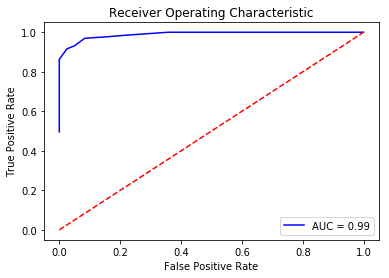

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,6668,3G7R.A,0.740741,0.000000,0.259259,alpha,"[-0.19266415596092965, -0.2399933855303309, 0....",0,alpha
1,9158,4RML.A,0.035433,0.535433,0.429134,beta,"[-0.21263451778504533, -0.014132911118213088, ...",1,beta
2,7513,5NKQ.H,0.000000,0.574713,0.425287,beta,"[-0.2171121690176673, -0.36940699795281495, 0....",1,beta
3,12862,1NLQ.D,0.000000,0.627660,0.372340,beta,"[-0.2656501144884485, 0.18032105315789998, 0.2...",1,beta
4,14932,2J43.B,0.045872,0.408257,0.545872,beta,"[-0.13283207215616533, 0.04328404277255503, 0....",1,beta
5,1189,3GQH.B,0.018405,0.484663,0.496933,beta,"[-0.34236295415479456, 0.22659847348422546, 0....",1,beta
6,12163,5KR2.A,0.040404,0.565657,0.393939,beta,"[-0.023600963856644775, 0.10966652802818891, 0...",1,beta
7,18435,5D66.B,0.515306,0.000000,0.484694,alpha,"[-0.03878455686378222, -0.035526998984027024, ...",0,alpha
8,13620,4DKA.C,0.000000,0.674419,0.325581,beta,"[-0.13583211455261335, -0.021207898335817914, ...",1,beta
9,6001,4BK0.B,0.577320,0.000000,0.422680,alpha,"[-0.13384959350594064, 0.04731130488216877, 0....",0,alpha


In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")

# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)    

print("Sample predictions: ")
mcc.prediction.head(10)

## Logistic Regression Classifier


 Class	Train	Test

alpha	1132	121

beta	1123	130

Total time taken: 0.7784938812255859

Methods	LogisticRegression
AUC	0.936554354736173
F Score	0.8854961832061069
Accuracy	0.8804780876494024
Precision	0.8787878787878788
Recall	0.8923076923076924
False Positive Rate	0.12121212121212122
True Positive Rate	0.8823529411764706
	
Confusion Matrix
['alpha' 'beta']
[[105  16]
 [ 14 116]]


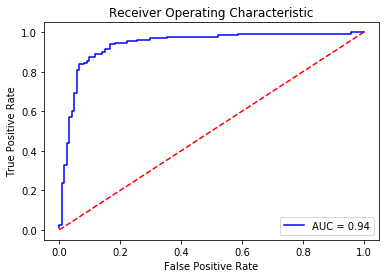

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,6443,5YOW.A,0.049412,0.538824,0.411765,beta,"[-0.14022701293204246, -0.15134377832638474, 0...",1,beta
1,2449,4R5R.A,0.000000,0.176471,0.823529,beta,"[-0.201321740412334, 0.13262236185038268, 0.36...",1,beta
2,16645,5Y9G.B,0.000000,0.553191,0.446809,beta,"[-0.009639994140613724, -0.138692404621759, 0....",1,beta
3,4970,3L32.A,0.840909,0.000000,0.159091,alpha,"[0.16809661373157395, 0.023070101583884523, 0....",0,beta
4,11784,2WL8.A,0.727273,0.000000,0.272727,alpha,"[0.022588662318885327, -0.11025200371444226, 0...",0,alpha
5,3857,4Q1W.A,0.040404,0.535354,0.424242,beta,"[0.002805970775495682, 0.041452450449673495, 0...",1,beta
6,12995,1M9Z.A,0.028571,0.438095,0.533333,beta,"[-0.17828402299095283, -0.04043481393971226, 0...",1,beta
7,16600,4ZOT.A,0.000000,0.466258,0.533742,beta,"[-0.3183537755317674, 0.027847847605715258, 0....",1,beta
8,383,3SRI.B,0.000000,0.320000,0.680000,beta,"[0.09553890036685125, -0.15003927158457891, 0....",1,beta
9,10910,5EZU.B,0.000000,0.686567,0.313433,beta,"[0.024517289198808034, -0.22955921535718848, 0...",1,beta


In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Simple Multilayer Perception Classifier


 Class	Train	Test

alpha	1128	125

beta	1127	126


/home/nick/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Total time taken: 3.765228271484375

Methods	MLPClassifier
AUC	0.9455238095238095
F Score	0.8769230769230769
Accuracy	0.8725099601593626
Precision	0.8507462686567164
Recall	0.9047619047619048
False Positive Rate	0.14925373134328357
True Positive Rate	0.8974358974358975
	
Confusion Matrix
['alpha' 'beta']
[[105  20]
 [ 12 114]]


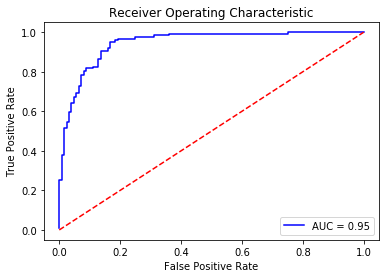

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,12306,4PND.B,0.931035,0.000000,0.068966,alpha,"[-0.05933205770949523, 0.34301356549064316, -0...",0,alpha
1,5448,2XQX.B,0.047945,0.486301,0.465753,beta,"[-0.1524068333146473, -0.09368410263210536, 0....",1,beta
2,3342,2XVC.B,0.000000,0.461538,0.538462,beta,"[-0.38914360857701724, 0.6226869065846715, 0.1...",1,beta
3,725,3ME0.B,0.000000,0.515625,0.484375,beta,"[-0.15092479744119439, -0.43194429536797396, 0...",1,beta
4,9177,4RT4.C,0.788462,0.000000,0.211538,alpha,"[0.08494837026183422, 0.13439124771035635, -0....",0,alpha
5,16848,1ZVZ.A,0.814229,0.007905,0.177866,alpha,"[-0.12455088487598483, -0.22477902145721287, 0...",0,alpha
6,15804,4CAY.C,0.217391,0.043478,0.739130,alpha,"[-0.4752181742725701, -0.3079662510547145, 0.0...",0,alpha
7,773,3MNM.A,0.000000,0.589286,0.410714,beta,"[0.052158838695251064, -0.10761640559820856, 0...",1,beta
8,2681,2NTX.B,0.731707,0.034843,0.233449,alpha,"[0.03346293962018176, -0.01965178857342555, -0...",0,alpha
9,7461,5JLV.C,0.030928,0.618557,0.350515,beta,"[-0.504933379686855, -0.42395369188281995, 0.4...",1,beta


In [8]:
from sklearn.neural_network import MLPClassifier

layers = [featureCount, 32, 32, classCount]
clf = MLPClassifier(solver='sgd', \
                    alpha=1e-5, \
                    hidden_layer_sizes = (32, 32))
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)

matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Terminate Spark

In [9]:
spark.stop()